#                Trabalho final Fundamentos de Data science

O objetivo desse trabalho é criar um classificador para identificar qual é a função do gene usando os dados de sequencias de DNA humano, ou de cachorro, ou de macaco

## Importando as bibliotecas e os dados

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import functools 
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [2]:
raw_human = pd.read_csv("../datasets/dna_human.txt", sep="\t")
raw_cachorro = pd.read_csv("../datasets/dna_cachorro.txt", sep="\t")
raw_macaco = pd.read_csv("../datasets/dna_macaco.txt", sep="\t")

---

## Os três dataset têm a mesma estrutura

In [3]:
raw_macaco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sequence  1682 non-null   object
 1   class     1682 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 26.4+ KB


In [4]:
raw_cachorro.head()

,sequence,class
0,ATGCCACAGCTAGATACATCCACCTGATTTATTATAATCTTTTCAA...,4
1,ATGAACGAAAATCTATTCGCTTCTTTCGCTGCCCCCTCAATAATAG...,4
2,ATGGAAACACCCTTCTACGGCGATGAGGCGCTGAGCGGCCTGGGCG...,6
3,ATGTGCACTAAAATGGAACAGCCCTTCTACCACGACGACTCATACG...,6
4,ATGAGCCGGCAGCTAAACAGAAGCCAGAACTGCTCCTTCAGTGACG...,0


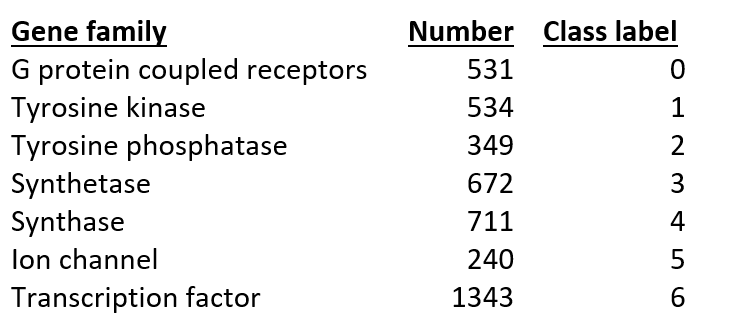

### Verificando se tem algum dado nulo

In [5]:
raw_human.isnull().values.any() or raw_human.isna().values.any()

False

In [6]:
raw_cachorro.isnull().values.any() or raw_cachorro.isna().values.any()

False

In [7]:
raw_macaco.isnull().values.any() or raw_macaco.isna().values.any()

False

### Verificando se estão balanceadas

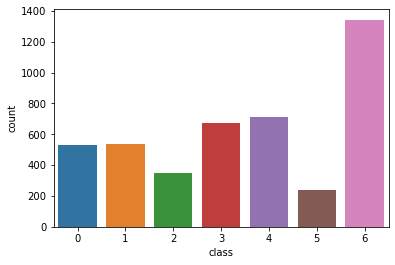

In [8]:
sns.countplot(x='class', data=raw_human)

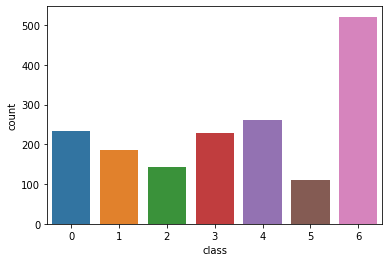

In [9]:
sns.countplot(x='class', data=raw_macaco)

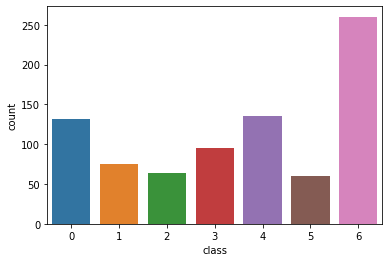

In [10]:
sns.countplot(x='class', data=raw_cachorro)

---

## Pré processamento

### Tratamento de bases que não existem no DNA

In [11]:
# Sustituir a base nitrogenada que for diferente de A,T,G,C por Z
# Colocar todas as letras em minúsculo
def tratar_nucleotidios_dna(sequencia):
    seq = sequencia.lower()
    seq = re.sub('[^atgc]', 'z', seq)
    return seq

### Gerando subsequências da sequência de DNA (K-mer)

In [12]:
# Por convenção o valor padrão de k é 6
def get_subsequencia_Kmers(sequencia, k=6):
    return [tratar_nucleotidios_dna(sequencia[i:i+k]) for i in range(len(sequencia) - k + 1)]

### Template método de pré processamento

In [13]:
def pre_process_seq(sequencia):
    array_kmers = get_subsequencia_Kmers(sequencia)
    return ' '.join(array_kmers)

In [14]:
raw_human['kmers'] = raw_human.apply(lambda x: pre_process_seq(x['sequence']), axis=1)
raw_cachorro['kmers'] = raw_cachorro.apply(lambda x: pre_process_seq(x['sequence']), axis=1)
raw_macaco['kmers'] = raw_macaco.apply(lambda x: pre_process_seq(x['sequence']), axis=1)

### Exemplo

In [15]:
raw_human.iloc[0]

sequence    ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...
class                                                       4
kmers       atgccc tgcccc gcccca ccccaa cccaac ccaact caac...
Name: 0, dtype: object

### Removendo a coluna sequence

In [16]:
humano = raw_human[['class', 'kmers']]
cachorro = raw_cachorro[['class', 'kmers']]
macaco = raw_macaco[['class', 'kmers']]

---

## Criando o Bag of Words de acordo com a frequência e transformando-os

Essa etapa é a fase onde transforma a sequência de strings em features númericas

In [17]:
# A chave do dicionário será composta por
# quatro grupos de seis bases hidrogenadas
count_vectorizer = CountVectorizer(ngram_range=(4,4))

### Treino e transformação

In [18]:
# Treinando só com o do humano pq ele tem o maior número de registros
X_humano = count_vectorizer.fit_transform(humano['kmers'])
X_humano.shape

(4380, 232414)

In [19]:
X_cachorro = count_vectorizer.transform(cachorro['kmers'])
X_cachorro.shape

(820, 232414)

In [20]:
X_macaco = count_vectorizer.transform(macaco['kmers'])
X_macaco.shape

(1682, 232414)

In [21]:
count_vectorizer.vocabulary_

{'atgccc tgcccc gcccca ccccaa': 52803,
 'tgcccc gcccca ccccaa cccaac': 207483,
 'gcccca ccccaa cccaac ccaact': 136621,
 'ccccaa cccaac ccaact caacta': 79202,
 'cccaac ccaact caacta aactaa': 78295,
 'ccaact caacta aactaa actaaa': 74681,
 'caacta aactaa actaaa ctaaat': 60650,
 'aactaa actaaa ctaaat taaata': 6563,
 'actaaa ctaaat taaata aaatac': 25724,
 'ctaaat taaata aaatac aatact': 101750,
 'taaata aaatac aatact atacta': 175710,
 'aaatac aatact atacta tactac': 3017,
 'aatact atacta tactac actacc': 11772,
 'atacta tactac actacc ctaccg': 46030,
 'tactac actacc ctaccg taccgt': 180840,
 'actacc ctaccg taccgt accgta': 25976,
 'ctaccg taccgt accgta ccgtat': 102780,
 'taccgt accgta ccgtat cgtatg': 179779,
 'accgta ccgtat cgtatg gtatgg': 21456,
 'ccgtat cgtatg gtatgg tatggc': 84717,
 'cgtatg gtatgg tatggc atggcc': 99209,
 'gtatgg tatggc atggcc tggccc': 163924,
 'tatggc atggcc tggccc ggccca': 186692,
 'atggcc tggccc ggccca gcccac': 53731,
 'tggccc ggccca gcccac cccacc': 211263,
 'ggccca gcccac c

---

## Criando a massa de treino e teste

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_humano, humano['class'], test_size=0.2, random_state=42)

In [23]:
X_train.shape

(3504, 232414)

In [24]:
X_test.shape

(876, 232414)

---

## Treinando os classificadores e pegando as previsões

### Naive Bayes

In [25]:
nb_classificador = MultinomialNB(alpha=0.1)
nb_classificador.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

### SVM

In [26]:
sv_classificador = SVC()
sv_classificador.fit(X_train, y_train)

SVC()

In [27]:
nb_y_predict = nb_classificador.predict(X_test)

In [28]:
sv_y_predict = sv_classificador.predict(X_test)

---

## Comparando as métricas

In [29]:
def resultado_comparacao(y_t, y_p):
    accuracy = accuracy_score(y_t, y_p)
    precision = precision_score(y_t, y_p, average='weighted')
    recall = recall_score(y_t, y_p, average='weighted')
    f1 = f1_score(y_t, y_p, average='weighted')
    
    print(f'Acuracia: {accuracy} | Precisao: {precision} | Recall: {recall} | F1: {f1} \n\n')
    print(pd.crosstab(y_t, y_p, rownames=['Real'], colnames=['Previsto']))

In [30]:
resultado_comparacao(y_test, nb_y_predict)

Acuracia: 0.9840182648401826 | Precisao: 0.984290543482443 | Recall: 0.9840182648401826 | F1: 0.9840270014702487 


Previsto   0    1   2    3    4   5    6
Real                                    
0         99    0   0    0    1   0    2
1          0  104   0    0    0   0    2
2          0    0  78    0    0   0    0
3          0    0   0  124    0   0    1
4          1    0   0    0  143   0    5
5          0    0   0    0    0  51    0
6          1    0   0    1    0   0  263


In [31]:
resultado_comparacao(y_test, sv_y_predict)

Acuracia: 0.8059360730593608 | Precisao: 0.8794382733892766 | Recall: 0.8059360730593608 | F1: 0.8127930778055618 


Previsto   0   1   2   3    4   5    6
Real                                  
0         71   0   0   0    0   0   31
1          0  73   0   0    0   0   33
2          1   0  60   0    0   0   17
3          0   0   0  93    0   0   32
4          1   0   0   0  113   0   35
5          0   0   0   0    0  31   20
6          0   0   0   0    0   0  265


#### Com os parâmetros atuais, o classificador que apresentou melhores índices foi Naive Bayes

---

## Prevendo a classificação para Macaco e Cachorro

In [32]:
y_pred_macaco = nb_classificador.predict(X_macaco)
y_pred_cachorro = nb_classificador.predict(X_cachorro)

In [33]:
resultado_comparacao(macaco['class'], y_pred_macaco)

Acuracia: 0.9934601664684899 | Precisao: 0.993551028649631 | Recall: 0.9934601664684899 | F1: 0.993453334125236 


Previsto    0    1    2    3    4    5    6
Real                                       
0         232    0    0    0    0    0    2
1           0  184    0    0    0    0    1
2           0    0  144    0    0    0    0
3           0    0    0  227    0    0    1
4           2    0    0    0  254    0    5
5           0    0    0    0    0  109    0
6           0    0    0    0    0    0  521


In [34]:
resultado_comparacao(cachorro['class'], y_pred_cachorro)

Acuracia: 0.925609756097561 | Precisao: 0.9340667154775472 | Recall: 0.925609756097561 | F1: 0.9251228556957126 


Previsto    0   1   2   3    4   5    6
Real                                   
0         127   0   0   0    0   0    4
1           0  63   0   0    1   0   11
2           0   0  49   0    1   0   14
3           1   0   0  81    2   0   11
4           4   0   0   1  126   0    4
5           4   0   0   0    1  53    2
6           0   0   0   0    0   0  260


## Conclusão

Com esse resultado podemos afirmar que o treino só com os dados de DNA dos humanos foram suficientes para ter bons acertos sobre a Classificação do Gene em DNAs de cachorro e macaco